The full Hamiltonian is of form:

$\begin{equation}H = \Delta_{pc} \sum^2_{i=1} a_i^{\dagger} a_i - \frac{\Delta_{pa}}{2} \sum^1_{i=0} \ket{i}\bra{i} + \frac{\Delta_{pa}}{2} \sum^5_{i=2} \ket{i}\bra{i}+ [\frac{\Omega}{2}(\ket{3}\bra{0} + \ket{4}\bra{1}) + \text{h.c.}] + \{g\{[(\frac{\ket{2} + \ket{4}}{\sqrt{2}})\bra{0}] + [(\frac{\ket{3} + \ket{5}}{\sqrt{2}})\bra{1}]\}a_1 + \text{h.c.}\} + \{g(\ket{0}\bra{3} + \ket{1}\bra{4})a_2 + \text{h.c.}\}\end{equation}$

and our jump operators are of form
$
\begin{align}
L_i &= \sqrt{2\gamma} \sigma_i^- \\
L_c &= \sqrt{2\kappa} a
\end{align}
$

In [9]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from tqdm import tqdm
from qutip.ui.progressbar import BaseProgressBar, TextProgressBar

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [10]:
# i'll just define some arbitrary parameters for now
Delta_pc = 1.0
Delta_pa = 1.2
Omega = 0.5      # rabi freq
g = 0.1          # coupling
gamma = 0.05     # atomic decay
kappa = 0.05     # cavity decay

In [11]:
# basis states
basis_states = [qt.basis(6, i) for i in range(6)]

# atomic and cavity operators
sigma_plus = [basis_states[i] * basis_states[i+1].dag() for i in range(5)]
sigma_minus = [op.dag() for op in sigma_plus]

num_fock = 5
a1 = qt.tensor(qt.qeye(6), qt.destroy(num_fock), qt.qeye(num_fock))
a2 = qt.tensor(qt.qeye(6), qt.qeye(num_fock), qt.destroy(num_fock))

$H = \Delta_{pc} \sum^2_{i=1} a_i^{\dagger} a_i$

$ -\frac{\Delta_{pa}}{2} (\ket{0}\bra{0} + \ket{1}\bra{1})$ 

$ +\frac{\Delta_{pa}}{2} (\ket{2}\bra{2} + \ket{3}\bra{3}+ \ket{4}\bra{4}+ \ket{5}\bra{5})$ 

$+ \frac{\Omega}{2}(\ket{3}\bra{0} + \ket{4}\bra{1}) + \text{h.c.}$

$+ g\{[(\frac{\ket{2} + \ket{4}}{\sqrt{2}})\bra{0}] + [(\frac{\ket{3} + \ket{5}}{\sqrt{2}})\bra{1}]\}a_1 + \text{h.c.} $

$+g(\ket{0}\bra{3} + \ket{1}\bra{4})a_2 + \text{h.c.}$

I'll break up the Hamiltonian a bit for readability

In [12]:
H_cavity = Delta_pc * (a1.dag() * a1 + a2.dag() * a2)

H_atomic = Delta_pa * qt.tensor(sum([basis_states[i] * basis_states[i].dag() for i in range(6)]), qt.qeye(5), qt.qeye(5))

H_drive = (Omega/2) * (
    qt.tensor(sigma_plus[3], qt.qeye(5), qt.qeye(5)) +
    qt.tensor(sigma_plus[4], qt.qeye(5), qt.qeye(5)) +
    qt.tensor(sigma_minus[3], qt.qeye(5), qt.qeye(5)) +
    qt.tensor(sigma_minus[4], qt.qeye(5), qt.qeye(5))
)

H_interaction_1 = g * (
    qt.tensor((basis_states[2] + basis_states[4])/np.sqrt(2) * basis_states[0].dag(), qt.destroy(5), qt.qeye(5)) +
    qt.tensor((basis_states[3] + basis_states[5])/np.sqrt(2) * basis_states[1].dag(), qt.destroy(5), qt.qeye(5)) +
    qt.tensor(basis_states[0] * basis_states[3].dag() + basis_states[1] * basis_states[4].dag(), qt.qeye(5), qt.destroy(5))
)

H_interaction_2 = g * (
    qt.tensor((basis_states[2] + basis_states[4])/np.sqrt(2) * basis_states[0].dag(), qt.destroy(5), qt.qeye(5)).dag() +
    qt.tensor((basis_states[3] + basis_states[5])/np.sqrt(2) * basis_states[1].dag(), qt.destroy(5), qt.qeye(5)).dag() +
    qt.tensor(basis_states[0] * basis_states[3].dag() + basis_states[1] * basis_states[4].dag(), qt.qeye(5), qt.destroy(5)).dag()
)

H = H_cavity + H_atomic + H_drive + H_interaction_1 + H_interaction_2

Quantum object: dims=[[6, 5, 5], [6, 5, 5]], shape=(150, 150), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1.2 0.  0.  ... 0.  0.  0. ]
 [0.  2.2 0.  ... 0.  0.  0. ]
 [0.  0.  3.2 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 7.2 0.  0. ]
 [0.  0.  0.  ... 0.  8.2 0. ]
 [0.  0.  0.  ... 0.  0.  9.2]]


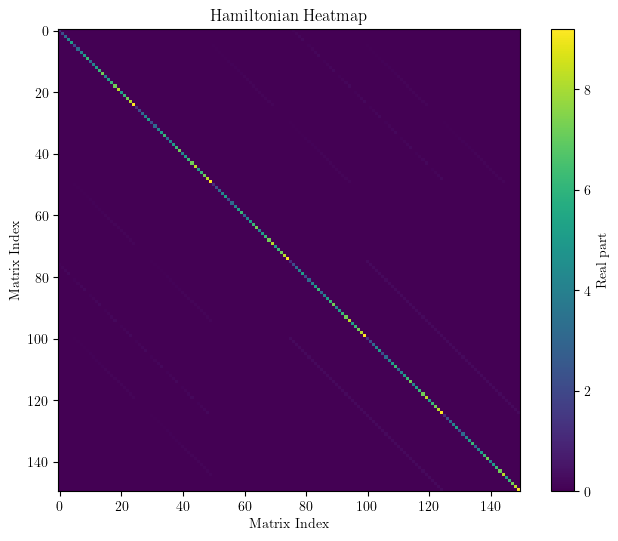

In [13]:
H_matrix = H.full()
print(H)

plt.figure(figsize=(8, 6))
plt.title("Hamiltonian Heatmap")
plt.imshow(np.real(H_matrix), cmap='viridis', interpolation='nearest')
plt.colorbar(label="Real part")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()

In [14]:
# jump ops
L_i = [np.sqrt(2 * gamma) * qt.tensor(basis_states[i] * basis_states[i].dag(), qt.qeye(5), qt.qeye(5)) for i in range(6)]
L_c = [np.sqrt(2 * kappa) * a1, np.sqrt(2 * kappa) * a2]

c_ops = L_i + L_c

# expectation values we want to look at
e_ops = [
    a1.dag() * a1,  
    a2.dag() * a2,  
    basis_states[0] * basis_states[0].dag(), 
    basis_states[1] * basis_states[1].dag(), 
    basis_states[2] * basis_states[2].dag(), 
    basis_states[3] * basis_states[3].dag(),  
    basis_states[4] * basis_states[4].dag(), 
    basis_states[5] * basis_states[5].dag(), 
]

Look at time dynamics

In [18]:
# Initial state and time evo
initial_state = qt.tensor(basis_states[0], qt.basis(5, 0), qt.basis(5, 0))
times = np.linspace(0, 5, 100)
print("Beginning time dynamics sim")
result = qt.mesolve(H, initial_state, times, c_ops, e_ops, progress_bar=True)

Beginning time dynamics sim


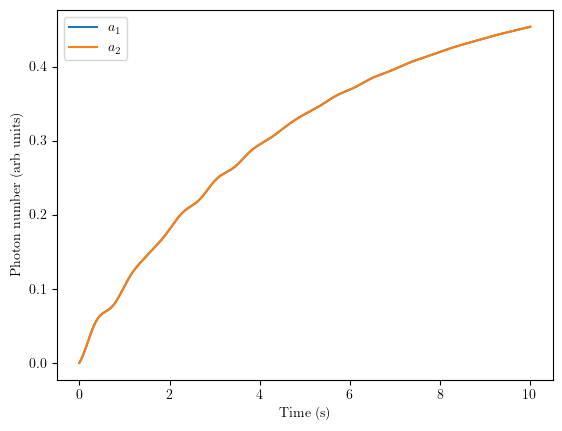

In [7]:
# plot photon numbers together
plt.plot(times, result.expect[0], label='$a_1$')
plt.plot(times, result.expect[1], label='$a_2$')
# add some style to the plot
plt.xlabel('Time (s)')
plt.ylabel('Photon number (arb units)')

plt.legend()
plt.show()

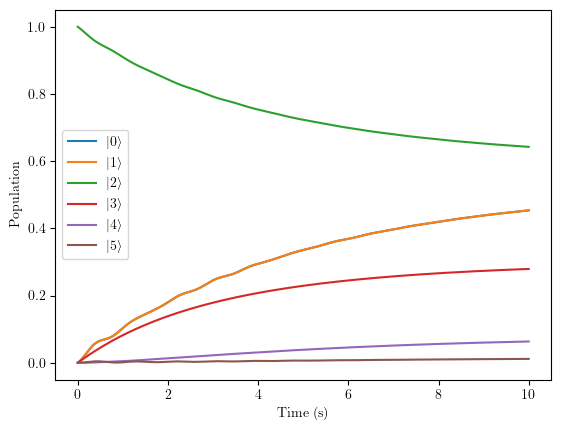

In [8]:
# plot all of the atomic populations
for i in range(0, 6):
    plt.plot(times, result.expect[i], label=f'$|{i}\\rangle$')
plt.xlabel('Time (s)')
plt.ylabel('Population')
plt.legend()
plt.show()

steady state

In [7]:
# also perform a steady state analysis
rho_ss = qt.steadystate(H, c_ops)
ss_e_ops = [
    a1.dag() * a1, 
    a2.dag() * a2,  
    basis_states[0] * basis_states[0].dag(),
    basis_states[1] * basis_states[1].dag(),  
    basis_states[2] * basis_states[2].dag(), 
    basis_states[3] * basis_states[3].dag(),  
    basis_states[4] * basis_states[4].dag(),  
    basis_states[5] * basis_states[5].dag(),  
]

ss_result = [qt.expect(e_op, rho_ss) for e_op in ss_e_ops]

KeyboardInterrupt: 

In [10]:
for i, val in enumerate(ss_result):
    print(f"Expectation value for operator {i}: {val}")

Expectation value for operator 0: 0.5212873946848035
Expectation value for operator 1: 0.5212873946848035
Expectation value for operator 2: 0.6002662393165081
Expectation value for operator 3: 0.30189157986600074
Expectation value for operator 4: 0.07853570912962038
Expectation value for operator 5: 0.015485876275672314
Expectation value for operator 6: 0.003236209328447015
Expectation value for operator 7: 0.0005843860837513801


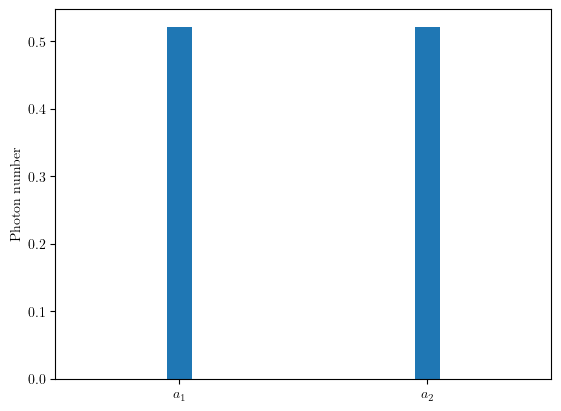

In [11]:
# plot steady state cavity numbers as bar graph
plt.bar(['$a_1$', '$a_2$'], ss_result[:2], width = 0.1)
plt.ylabel('Photon number')

plt.xlim(-0.5, 1.5)

plt.show()

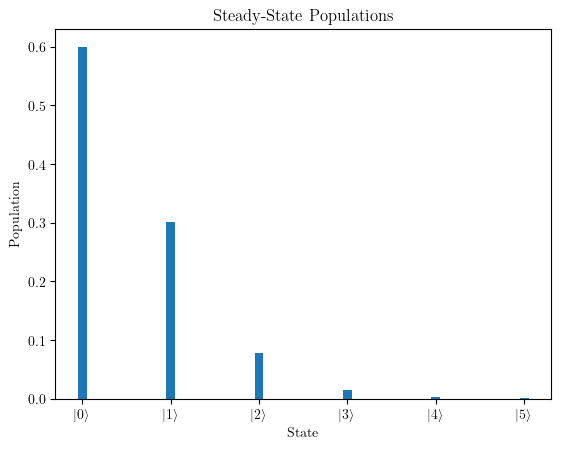

In [12]:
# atomic populations
plt.bar(range(6), ss_result[2:], tick_label=[f'$|{i}\\rangle$' for i in range(6)], width = 0.1)
plt.xlabel('State')
plt.ylabel('Population')
plt.title('Steady-State Populations')
plt.show()